In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


In [2]:
def scatter(pts):
  # pts - DxN array
  plt.scatter(*pts)
  plt.grid(True)
  plt.gca().set_aspect('equal')
  plt.xlim(-4,4)
  plt.ylim(-4,4)
  # plt.show()

# Prinicipal Component Analysis

## TODO:
- why isn't the projection perfect?
- isometric graphs
- motivation

## Introduction
We start with some dataset $\mathbf X\in M_{k\times n}$ of $n$ $k$-dimensional samples from some distribution. For each unit vector $v$ we can project $\mathbf X$ onto $v$ and calculate the variance of the projection. Some directions will vary more than others, and we can try to choose some orthogonal [Why orthogonal?] set of such vectors, ordered by variance. Let's give it a try. First we sample some points

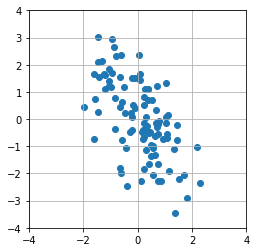

In [3]:
N = 100
X = np.random.multivariate_normal([0,0], [[1,-1],[-1,2]], N).T
scatter(X)

Now we can try to look the projection of this points on some chosen direction

var of projection onto v=[1. 0.] is 0.8352148181779545


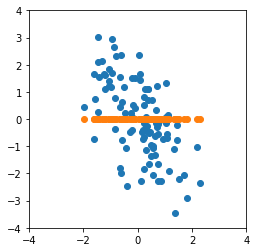

var of projection onto v=[0.24253563 0.9701425 ] is 1.5358691412309953


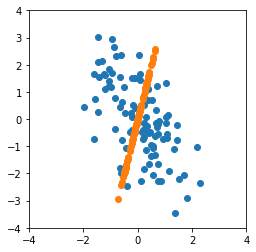

In [4]:
def plot_proj(X, *vs):
    scatter(X)
    for v in vs:
        proj = v @ X
        scatter(proj * v[:,None])
    print(f"var of projection onto v={v} is {(v @ X).var()}")
    plt.grid()
    plt.show()


v = np.array([1,0])
v = v / np.linalg.norm(v)
plot_proj(X, v)

v = np.array([1,4])
v = v / np.linalg.norm(v)
plot_proj(X, v)

We can see along one direction the variance is larger. Motivated by the introduction, we try and search for the direction of largest variance. Since this problem is convex [Show!] we can use gradient ascent. Of course, the tricky part is we are actually in a constrained optimization but with a naive parametrization and some tricks we can get it to work

In [5]:
# TODO: better parametrization
def ascend(X, seed=None):
    np.random.seed(seed)
    flip = X[0].var() > X[1].var() # hack for numeric instability
    if flip:
        X = np.flip(X, axis=0)
        
    a = np.random.uniform(-1,1);
    for i in range(1000):
        v = np.array([a, np.sqrt(1-a**2)])
        proj = v @ X
        lr = 7e-4
        da = (proj * ([1, -a/np.sqrt(1-a**2)] @ X)).sum() # gradient with respect to a
        assert -1 < a + lr * da < 1, "a out of bounds"
        
        #update step
        a = a + lr * da
    v = np.array([a, np.sqrt(1-a**2)])
    if flip:
        v = np.array([np.sqrt(1-a**2), a])
    return v

var of projection onto v=[-0.45161184  0.89221452] is 2.3458039948311527


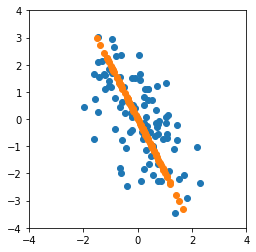

In [6]:
ev1 = ascend(X)
plot_proj(X, ev1)

Walla! we (apparently) managed to find what we wanted. How can we go about finding the second direction? If we will eventually get a collection of orthogonal vectors, then each datapoint will be a linear combination of these vectors. Maybe if we subtract our first vector from the dataset and repeat the process, we will get the next vector? [meh, i don't like this reasoning]

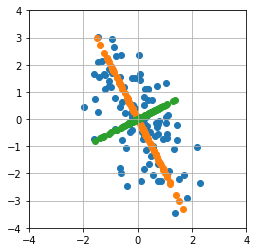

In [7]:
scatter(X)
scatter((ev1 @ X * ev1[:, None]))
scatter((X - ev1 @ X * ev1[:, None]))

var of projection onto v=[0.89221452 0.45161184] is 0.4503241138070732


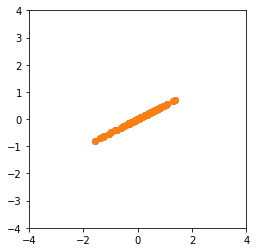

In [8]:
X1 = X - ev1 @ X * ev1[:, None]
ev2 = ascend(X1)
plot_proj(X1, ev2)

var of projection onto v=[0.89221452 0.45161184] is 0.4503241138070732


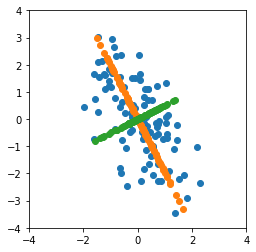

In [9]:
ev2 = ev2 / np.linalg.norm(ev2)
plot_proj(X, ev1, ev2)

In [10]:
O = np.c_[ev1,ev2]
O @  (X @ X.T / N) @ O.T

array([[2.34677987e+00, 1.03365123e-15],
       [1.25471309e-15, 4.54876571e-01]])

Theoretically, we could repeat this procedure $k$ times as the number of the features, but it's iterative nature is somewhat problematic. Instead, lets examine what we are calculating more carefully. In the optimization we are trying to minimize the empirical variance of the projection
$$\min_{v,\|v\|=1} Var(v^TX)$$
it can also be written as
$$\min_{v,\|v\|=1} \frac{v^TXX^Tv}{n}=v^T\left(\frac{XX^T}{n}\right)v$$
The matrix $XX^T$ is symmetric and so can be diagonalized, ie, there exists an orthogonal matrix $O$ and diagonal matrix $D$ (holding $XX^T$'s eigenvalues in descending order such that 
$$XX^T=O D O^T$$
Rewriting (and ignoring the constant $n$) we get
$$\min_{v,\|v\|=1} v^TODO^Tv$$
Since $O$ is orthogonal it keeps the unit circle intact, so if we denote $u=O^Tv$ we can optimize directly on $u$
$$\min_{u,\|u\|=1} u^TDu$$
You can convince yourself that the minimizing vector will be $e_1$, the first standard basis vector, and thus we get
$$v=Oe_1$$
which will be the first eigenvector of $XX^T$. This similarly extends to the rest of the principal directions. Thus we really only need to find the eigenvectors of $XX^T$.

var of projection onto v=[ 0.45161184 -0.89221452] is 2.345803994831152


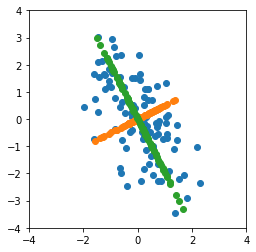

In [11]:
values, vectors = np.linalg.eig(X@X.T/N)
plot_proj(X, *vectors.T)

In practice we actually compute another decomposition called the *Singular Value Decomposition* which operates on $X$ directly (thus saving the matrix multiplication). It is related to the eigenvalue decomposition and gives us the principal components.

In [12]:
U, D, Vh = np.linalg.svd(X)

var of projection onto v=[0.89221452 0.45161184] is 0.4503241138070732


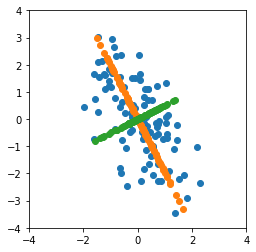

In [13]:
plot_proj(X, *U.T)

## Uses

### PCA in images

running out of ram - used `full_matrices=False`  
[Eigenfaces](https://en.wikipedia.org/wiki/Eigenface)

In [14]:
import torchvision.datasets as dset
mnist = dset.MNIST('./mnist/', download=True)
train = mnist.data.numpy()
labels = mnist.targets
N = train.shape[0]

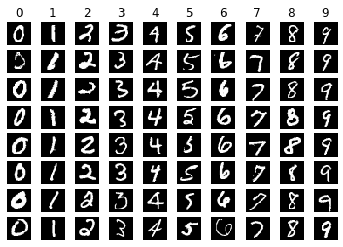

In [15]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = list(range(10))
for cls, cls_name in enumerate(classes):
    idxs = np.where((labels == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

In [16]:
train_v = train.reshape(N, -1)

In [19]:
U, S, Vh = np.linalg.svd(train_v, full_matrices=False)

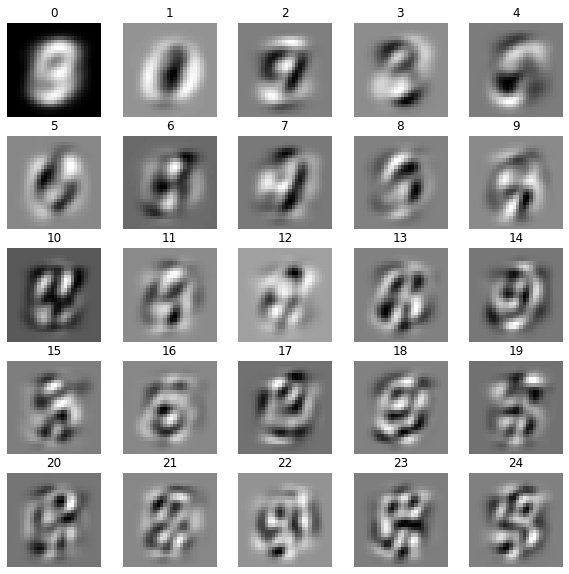

In [46]:
size = 5
plt.figure(figsize=(10,10))
for i, idx in enumerate(range(size**2)):#range(size**2):
  plt.subplot(size, size, i+1)
  plt.imshow(Vh[idx].reshape(28,28))
  plt.axis('off')
  plt.title(idx)

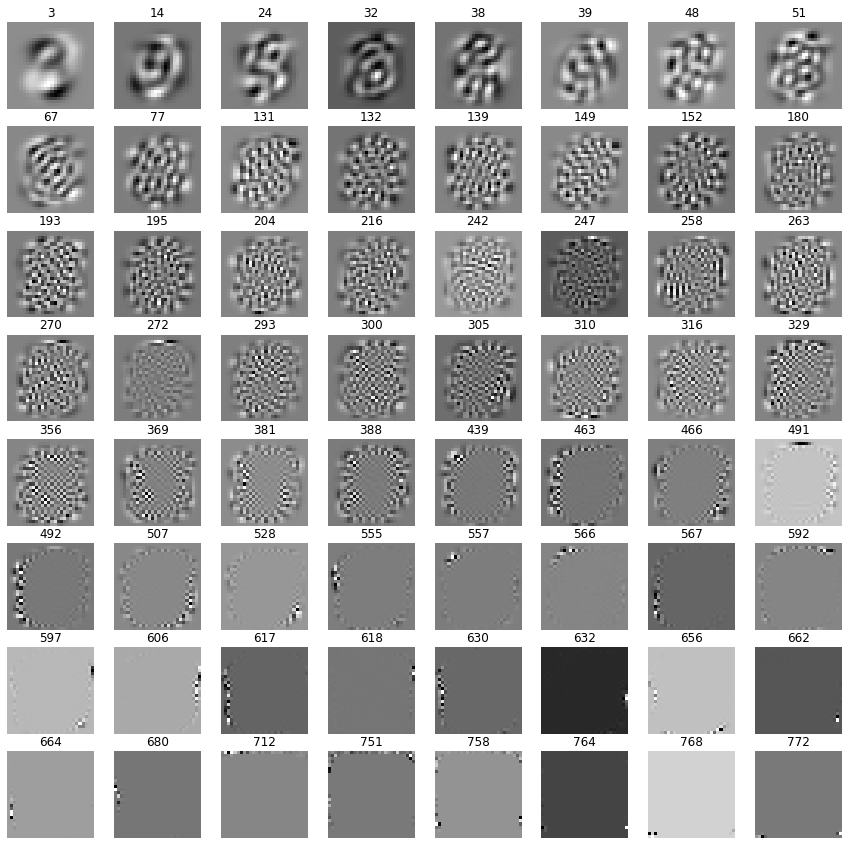

In [47]:
size = 8
plt.figure(figsize=(15,15))
for i, idx in enumerate(sorted(np.random.choice(list(range(Vh.shape[0])), size=size*size, replace=False))):#range(size**2):
  plt.subplot(size, size, i+1)
  plt.imshow(Vh[idx].reshape(28,28))
  plt.axis('off')
  plt.title(idx)

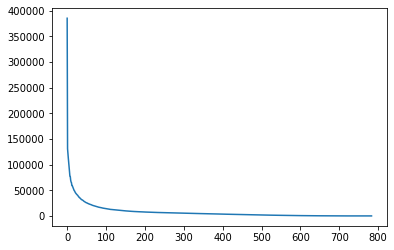

In [23]:
plt.plot(S)